### **Análisis Exploratorio de Datos**

In [45]:
#Se importan las librerias correspondientes
import os
import pyspark
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import year
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import  IntegerType, StringType, DateType
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


In [3]:
#Se confirma que los datos se encuentren en el espacio de trabajo 
if  not (os.path.isdir("raw") and os.path.isfile(os.path.join("trusted", 'trafico_aereo_1992_2022.csv'))):
    import preprocess
    preprocess

Se creo el folder raw
Descargando archivos: 


100%|██████████| 75/75 [00:48<00:00,  1.55it/s]


Elementos eliminados ['\\Enero 2023.xlsx']
Espere un momento...
Leyendo archivos: 


100%|██████████| 74/74 [05:36<00:00,  4.54s/it]


Se creo el folder trusted
Se creó el archivo 'trafico_aereo_1992_2022.csv' 


In [4]:
# creamos el contexto y la sesión
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()
spark

In [6]:

#Se define el esquema de la tabla
schema = StructType([
    StructField('Fecha', DateType()),
    StructField('Sigla Empresa', StringType()),
    StructField('Origen', StringType()),
    StructField('Destino', StringType()),
    StructField('Pasajeros', IntegerType()),
    StructField('Trafico', StringType()),
    StructField('TipoVuelo', StringType()),
    StructField('Ciudad Origen', StringType()),
    StructField('Ciudad Destino', StringType()),
    StructField('Pais Origen', StringType()),
    StructField('Pais Destino', StringType()),
    StructField('Nombre Empresa', StringType()),
    StructField('Apto_Origen', StringType()),
    StructField('Apto_Destino', StringType()),
])

In [7]:
#Se lee el archivo de trusted
filepath = os.path.join("trusted", 'trafico_aereo_1992_2022.csv')
data = spark.read.csv(filepath, header=True, schema=schema)
data.show(n=3)

+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+
|     Fecha|Sigla Empresa|Origen|Destino|Pasajeros|Trafico|TipoVuelo|Ciudad Origen|Ciudad Destino|   Pais Origen|Pais Destino|Nombre Empresa|         Apto_Origen|        Apto_Destino|
+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+
|2019-04-01|          AAL|   ABQ|    BOG|       37|      I|        R| NUEVO MEXICO|        BOGOTA|ESTADOS UNIDOS|    COLOMBIA|      AMERICAN|ALBUQUERQUE INTL ...|   BOGOTA - ELDORADO|
|2019-04-01|          AAL|   ABZ|    CLO|        1|      I|        R|     ABENDEEN|          CALI|    INGLATERRA|    COLOMBIA|      AMERICAN|                CYDE|CALI - ALFONSO BO...|
|2019-04-01|          AAL|   AMS|    CTG|        2|      I|        R|    AMSTERD

**¿Cómo ha evolucionado el tráfico aéreo, visto como el número de pasajeros, a través de los años?**

In [52]:

pasajeros_anho = data.select(
                "Fecha",
                "Pasajeros", 
                year("Fecha").alias("año")
                ).groupBy("año").agg(
                    sum("Pasajeros").alias("total_pasajeros")).toPandas()

pasajeros_anho_empresa = data.select(
                        "Pasajeros",
                        "Nombre Empresa",
                        year("Fecha").alias("año")
                        ).groupBy(["año", "Nombre Empresa"]).agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

pasajeros_empresa = data.select(
                        "Pasajeros",
                        "Nombre Empresa",
                        ).groupBy("Nombre Empresa").agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [53]:
pasajeros_anho["año"] = pasajeros_anho["año"].astype("Int64")
pasajeros_anho.dropna(inplace=True)


<Axes: xlabel='año'>

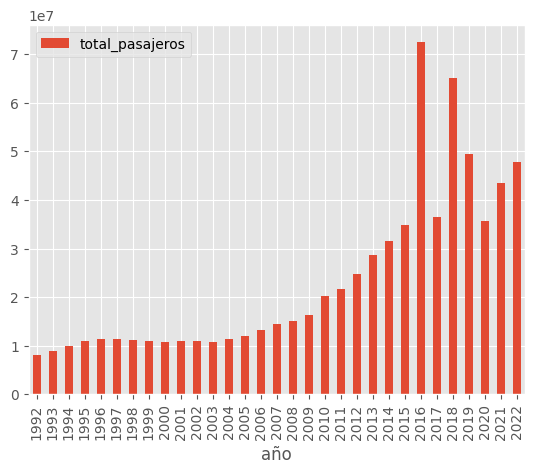

In [54]:
pasajeros_anho.set_index("año").sort_index().plot(kind="bar")

In [57]:
pasajeros_empresa.dropna(inplace=True)


<Axes: ylabel='Nombre Empresa'>

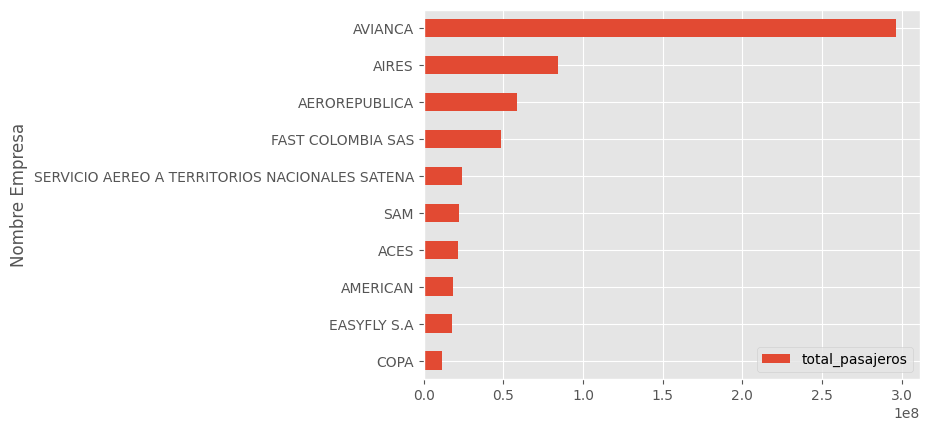

In [64]:
pasajeros_empresa.sort_values("total_pasajeros", ascending=False)[:10].sort_values("total_pasajeros").set_index("Nombre Empresa").plot(kind="barh")